In [1]:
import pandas as pd
import numpy as np
import patsy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#ad_df.replace(' ?', 'Missing', inplace=True)
#ad_df.head()
#ad_df.info()
#replace ? with numpy nan to enable fillna and mean functions
#votes_df.replace(['y', 'n', '?'], [1, 0, np.nan], inplace=True)
#votes_df.fillna(votes_df.mean(), inplace=True)
#votes_df.head(5)

def getCleanData(csvFileName):
    '''Reads in csv in the local folder and returns clean data frame'''
    ad_df = pd.read_csv(csvFileName)

    #Convert int64 to object to use in dmatrix
    ad_df['ADTIND'] = ad_df['ADTIND'].apply(str)
    ad_df['ADTOCC'] = ad_df['ADTOCC'].apply(str)
    ad_df['SEOTR'] = ad_df['SEOTR'].apply(str)
    ad_df['VETYN'] = ad_df['VETYN'].apply(str)

    #Create dummy vars
    ad_df_patsy = patsy.dmatrix("ACLSWKR\
                                +ADTIND\
                                +ADTOCC\
                                +AHGA\
                                +AHSCOL\
                                +AMARITL\
                                +AMJIND\
                                +AMJOCC\
                                +ARACE\
                                +AREORGN\
                                +ASEX\
                                +AUNMEM\
                                +AUNTYPE\
                                +AWKSTAT\
                                +CAPGAIN\
                                +CAPLOSS\
                                +DIVVAL\
                                +FILESTAT\
                                +GRINREG\
                                +GRINST\
                                +HHDFMX\
                                +HHDREL\
                                +MIGMTR1\
                                +MIGMTR3\
                                +MIGMTR4\
                                +MIGSAME\
                                +MIGSUN\
                                +NOEMP\
                                +PARENT\
                                +PEFNTVTY\
                                +PEMNTVTY\
                                +PENATVTY\
                                +PRCITSHP\
                                +SEOTR\
                                +VETQVA\
                                +VETYN-1", data=ad_df, return_type='dataframe')
    
    #Get non categorical fields and replace target with 1 and 0
    ad_df_for_model= ad_df[['AAGE','WKSWORK','YEAR','AHRSPAY','DIVVAL','CAPGAIN','CAPLOSS','NOEMP','INCOME_IND']].replace(['-50000', ' 50000+.'], [0, 1])
    
    #Add dummy matrix
    ad_df_for_model = pd.merge(ad_df_patsy,ad_df_for_model, right_index=True, left_index=True)
    
    print ad_df_for_model.info()
    
    return ad_df_for_model

In [2]:
trainingData = getCleanData('census-income.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199523 entries, 0 to 199522
Columns: 483 entries, ACLSWKR[ Federal government] to INCOME_IND
dtypes: float64(474), int64(9)
memory usage: 736.8 MB
None


In [3]:
#Have to drop one column since it's missing in test data
#The better way is to impute this column in test data
#For now just do MVP
trainingData = trainingData.drop("HHDFMX[T. Grandchild <18 ever marr not in subfamily]", 1)

In [4]:
#Split for training 
X = trainingData[trainingData.columns[:-1]]
y = trainingData[trainingData.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [6]:
y_train.value_counts()

0    149659
1      9959
Name: INCOME_IND, dtype: int64

The following was to start a Gradient Boosting model. 


In [8]:
import pandas as pd
import numpy as np
import re
%pylab inline
import sklearn as skl
import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence as PDP
from sklearn.externals import joblib 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn import preprocessing
from __future__ import print_function
import statsmodels.api as sm
import statsmodels.formula.api as smf
#import xgboost as xgb
import copy
from sklearn.cross_validation import train_test_split
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [11]:
XGB_model = GBC(
                learning_rate=0.1, n_estimators=100, subsample=1.0,max_depth=3,
                                    )

XGB_model.fit(X_train, y_train)
pred_y_train = XGB_model.predict_proba(X_train)[:,1]
pred_y_test = XGB_model.predict_proba(X_test)[:,1]

In [23]:
XGB_model.feature_importances_
#len(XGB_model.feature_importances_)

array([  1.60564840e-03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.27572543e-03,   1.66790520e-02,
         0.00000000e+00,   4.40479636e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   7.14560780e-04,
         0.00000000e+00,   5.64026975e-03,   0.00000000e+00,
         3.83928425e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.56746721e-04,   0.00000000e+00,   4.10485618e-03,
         5.38381395e-03,   0.00000000e+00,   0.00000000e+00,
         3.70942670e-04,   0.00000000e+00,   5.60902704e-04,
         0.00000000e+00,   0.00000000e+00,   1.06980080e-03,
         0.00000000e+00,   8.95164301e-05,   0.00000000e+00,
         0.00000000e+00,   7.40067270e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         8.82691569e-04,   4.30393255e-03,   0.00000000e+00,
         0.00000000e+00,

In [14]:
def somersd(score, target, bins=500):
    pred = np.array([score, target]).T
    score, target = pred[pred.argsort(0)[:,0]].T
    #score, target = np.array(pd.DataFrame(pred).sort((0,1))).T
    
    n_1=float(sum(target))
    n_0=float(len(score)-n_1)
    
    pct_1=[0.0]
    pct_0=[0.0]

    for i in xrange(bins):
        end = int(float(i+1)/bins*len(pred))
        c_1 = sum(target[0:end])
        pct_1.append(c_1/n_1)
        pct_0.append((end-c_1)/n_0)

    pct_1.append(1.0)
    pct_0.append(1.0)
    
    sd=[(pct_1[i+1]+pct_1[i])*(pct_0[i+1]-pct_0[i]) for i in xrange(bins)]
    
    somersd=1-sum(sd)
    return somersd

def somers_plots(preds, bins=40):
    figsize(16,8)
    df = pd.DataFrame()
    for model, pred in preds.iteritems():
        mname = str(model)[:str(model).find("(")]
        #p = np.array(pd.DataFrame(pred).sort((0,1)))
        p = pred[pred.argsort(0)[:,0]]
        pct = []
        for i in xrange(bins):
            start = int(float(i)/bins*len(p))
            end = int(float(i+1)/bins*len(p))
            pct.append((i, np.mean(p[start:end,1])))
        pct = np.array(pct)
        for i in pct[:,1]:
            print (i)
        som = ' (%.3f)' % somersd(p[:,0], p[:,1])
        df = pd.concat([df, pd.DataFrame([pct, mname+som, som]).T])
         
    for k, v in df.sort(2, ascending=False).iterrows():
        pct = v.get_values()[0]
        plot(pct[:,0], pct[:,1], label=v[1])
    
    ylim(0,0.8)
    legend(loc='lower right')
    show()

0.0
0.0
0.0
0.0
0.0
0.000250595163513
0.00137827339932
0.00162886856284
0.00438541536148
0.00426011777973
0.00651629072682
0.00977321137702
0.0101491041223
0.0186693396817
0.0256860042601
0.0441047487783
0.0691642651297
0.12554817692
0.250093973186
0.676231048741
0.0
0.0
0.0
0.0
0.0
0.0
0.00250626566416
0.00150300601202
0.00250626566416
0.00701754385965
0.00751879699248
0.00901803607214
0.00952380952381
0.0145363408521
0.0300751879699
0.0460921843687
0.0651629072682
0.122807017544
0.245614035088
0.650300601202


c:\Users\mhi299\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


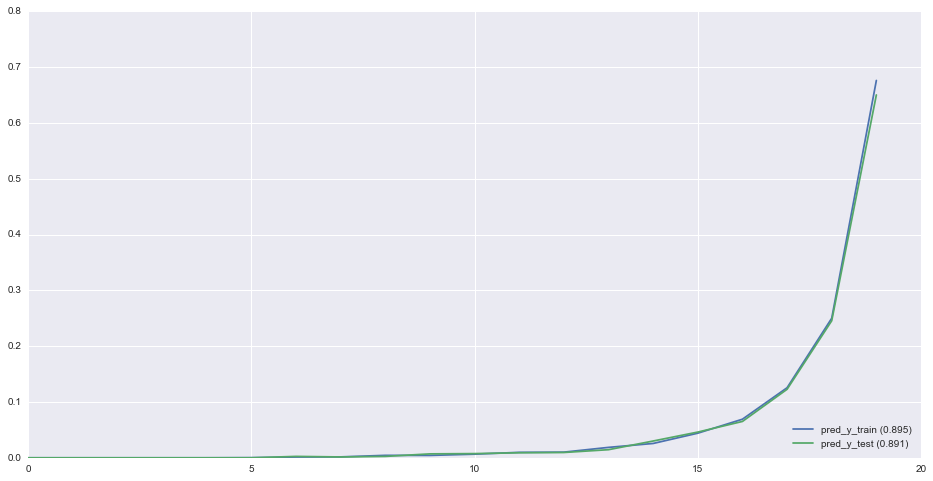

In [15]:
preds={} 
preds["pred_y_train "] = np.array(zip(pred_y_train, y_train))
preds["pred_y_test "] = np.array(zip(pred_y_test, y_test))
somers_plots(preds, bins=20)

The second model is LASSO based model

In [25]:
from sklearn.linear_model import LassoCV
clf = LassoCV(cv=20).fit(X_train, y_train)

pred_y_lasso_train = clf.predict(X_train)
pred_y_lasso_test = clf.predict(X_test)


0.000125313283208
0.0
0.0
0.0
0.0
0.00100238065405
0.00400952261621
0.00714196216013
0.00701666457837
0.00889612830472
0.0164160401003
0.0464854028317
0.0339556446561
0.0260618970054
0.0630246836236
0.107755920311
0.138579125423
0.151985966671
0.208119283298
0.42726475379
0.000501253132832
0.0
0.0
0.0
0.0
0.000501253132832
0.0015037593985
0.00501002004008
0.00952380952381
0.0110275689223
0.0135338345865
0.0490981963928
0.0320802005013
0.015037593985
0.0611528822055
0.0981963927856
0.144360902256
0.148370927318
0.209022556391
0.415330661323


c:\Users\mhi299\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


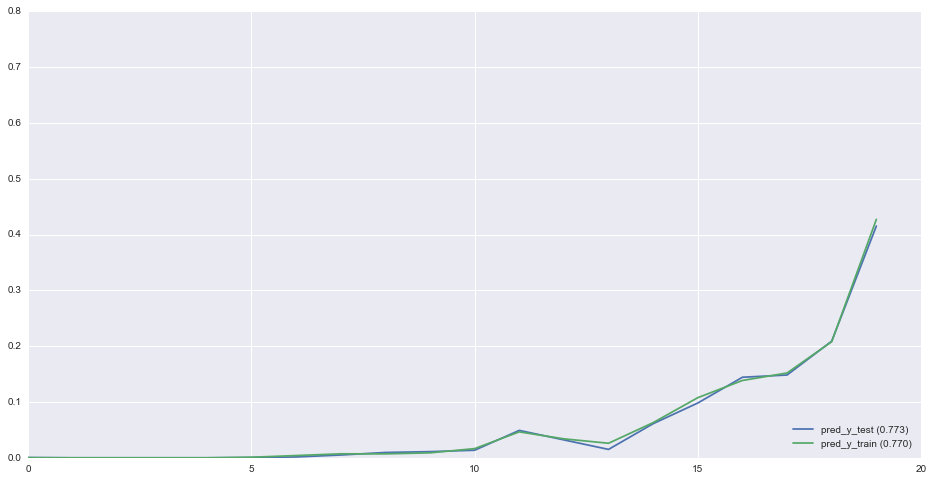

In [27]:
preds_lasso={} 
preds_lasso["pred_y_train "] = np.array(zip(pred_y_lasso_train, y_train))
preds_lasso["pred_y_test "] = np.array(zip(pred_y_lasso_test, y_test))
somers_plots(preds_lasso, bins=20)

In [18]:
y_test

48494     0
81905     0
155547    1
142557    0
2057      0
72455     0
80207     0
43408     0
69943     0
85648     0
91223     0
185715    0
47053     0
75735     0
151568    1
19247     0
182569    1
15387     0
50457     0
188382    0
25057     1
191696    0
63881     0
90862     0
184677    0
120081    0
135398    0
32060     0
139683    0
19665     0
         ..
187022    0
172391    0
58047     0
23807     0
14832     0
5060      0
199336    1
36837     0
139527    0
5081      1
90258     0
49625     0
5276      0
99694     0
147461    1
48280     0
40540     0
131010    0
46543     0
59635     0
164620    0
190759    0
62593     0
167093    0
66512     0
96263     0
133863    0
94786     0
135966    0
99735     0
Name: INCOME_IND, dtype: int64